In [1]:
import torch
import torch.nn as nn
import numpy as np
import copy
import matplotlib.pyplot as plt
import time

import torch_tmm
from torch_tmm import Dispersion, Material, Model, Layer, T_matrix, OpticalCalculator

from tmm_tests.test_dispersion import dispersion_sanity_test
from tmm_tests.test_material import material_sanity_check
from tmm_tests.test_layer import layer_sanity_check
from tmm_tests.tests_t_matrix import interface_test, coherent_layer_test

In [2]:
#Set dtype, device, wvl, angles
dtype = torch.float32
device = torch.device('cpu')

wavelengths = torch.linspace(400, 800, 801)
angles = torch.linspace(0, 89, 357)

Calc. time: 0.7803590297698975 s


(0.0, 1.0)

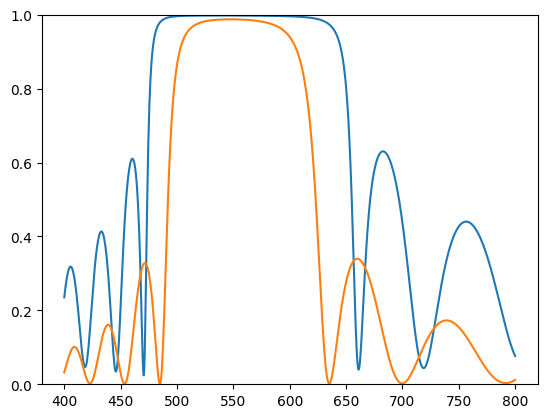

In [3]:
#Bragg mirror example

#Subs material
subs_mat = Material([Dispersion.Constant_epsilon(1.46**2)], name='Fused-silica')
#Env material
env_mat = Material([Dispersion.Constant_epsilon(1)], name='Air')
#TiO2_layer_material
TiO2_mat = Material([Dispersion.Cauchy(A=2.1, B=1, D=0.001)], name='TiO2') #With small absorption

#Create layers
env = Layer(env_mat, layer_type='semi-inf')
subs = Layer(subs_mat, layer_type='semi-inf')

structure = []
for i in range(10):
    structure.append(Layer(TiO2_mat, layer_type='coh', thickness=600/(4*2.1)))
    structure.append(Layer(subs_mat, layer_type='coh', thickness=600/(4*1.46)))

    

optical_model = Model(env=env, structure=structure, subs=subs,
                                dtype=dtype, device=device)
start = time.time()
calc = optical_model(wavelengths, angles)


Rs = calc.reflection('s')
Rp = calc.reflection('p')

finish = time.time()
print(f'Calc. time: {finish - start} s')

theta = torch.where(angles == 45)

plt.plot(wavelengths, Rs[:,theta])
plt.plot(wavelengths, Rp[:,theta])
plt.ylim([0, 1])


Calc. time: 0.06900191307067871 s


Text(0, 0.5, 'Transmission')

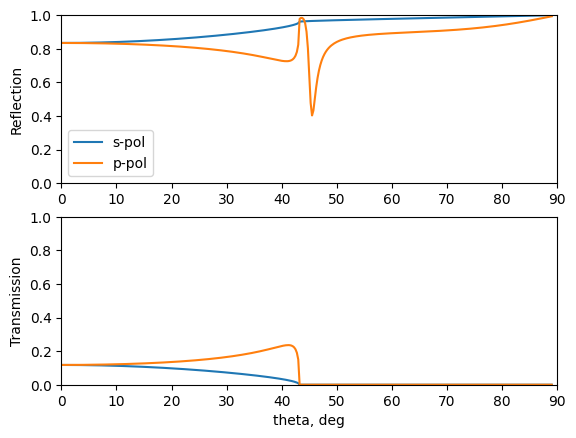

In [4]:
#Plasmon resonance example

#Subs material
subs_mat = Material([Dispersion.Constant_epsilon(1)], name='Air')
#Env material
env_mat = Material([Dispersion.Constant_epsilon(1.46**2)], name='Fused-silica')
#Metal layer material
metal_mat = Material([Dispersion.Lorentz(A=80, E0=0.845, Gamma=0.1),
                      Dispersion.Constant_epsilon(1)], name='Metal')

#Create layers
env = Layer(env_mat, layer_type='semi-inf')
subs = Layer(subs_mat, layer_type='semi-inf')
metal = Layer(metal_mat, layer_type='coh', thickness=25)


optical_model = Model(env=env, structure=[metal], subs=subs,
                                dtype=dtype, device=device)
start = time.time()
calc = optical_model(wavelengths, angles)


Rs = calc.reflection('s')
Rp = calc.reflection('p')
Ts = calc.transmission('s')
Tp = calc.transmission('p')

finish = time.time()
print(f'Calc. time: {finish - start} s')

wvl = torch.where(wavelengths == 532)

plt.subplot(2, 1, 1)
plt.plot(angles, Rs[wvl,:][0], label='s-pol')
plt.plot(angles, Rp[wvl,:][0], label='p-pol')
plt.ylabel('Reflection')
plt.legend()
plt.ylim([0, 1])
plt.xlim([0, 90])

plt.subplot(2, 1, 2)
plt.plot(angles, Ts[wvl,:][0])
plt.plot(angles, Tp[wvl,:][0])
plt.ylim([0, 1])
plt.xlim([0, 90])
plt.xlabel('theta, deg')
plt.ylabel('Transmission')